In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd, seaborn as sns
pd.set_option('display.max_rows', 8)
%matplotlib inline

# Diffusion Limited Aggregation in Vivarium

From https://en.wikipedia.org/wiki/Diffusion-limited_aggregation --- Diffusion-limited aggregation (DLA) is the process whereby particles undergoing a random walk due to Brownian motion cluster together to form aggregates of such particles.

In [2]:
import vivarium, vivarium.test_util as vtu, sklearn.neighbors

run_length_days = 10_000
population_size = 1_000_000

In [3]:
class DLA:
    def setup(self, builder):
        self.stickiness = .1  # TODO: use config
        
        columns = ['x', 'y', 'frozen']
        self.population_view = builder.population.get_view(columns)
        builder.population.initializes_simulants(self.on_initialize_simulants, creates_columns=columns)
        
        builder.event.register_listener('time_step', self.on_time_step)
        
    def on_initialize_simulants(self, simulant_data):
        """Start new simulants at random location, but 
        make sure there is something frozen at the origin
        """
        pop = pd.DataFrame(index=simulant_data.index)
        
        pop['x'] = np.random.normal(scale=100, size=len(pop))
        pop['y'] = np.random.normal(scale=100, size=len(pop))

        pop['frozen'] = False

        pop.loc[0, :] = [0, 0, True]
        
        # update the population in the model
        self.population_view.update(pop)
        
    def on_time_step(self, event):
        pop = self.population_view.get(event.index)
        
        # move the not-frozen
        pop.x += np.where(~pop.frozen, np.random.normal(scale=.1, size=len(pop)), 0)
        pop.y += np.where(~pop.frozen, np.random.normal(scale=.1, size=len(pop)), 0)
        
        # freeze
        to_freeze = self.near_frozen(pop)
        pop.loc[to_freeze, 'frozen'] = (np.random.normal(size=len(to_freeze)) < self.stickiness)
        self.population_view.update(pop)
        
    def near_frozen(self, pop):
        X = pop[pop.frozen].loc[:, ['x', 'y']].values
        tree = sklearn.neighbors.KDTree(X, leaf_size=2)
        
        not_frozen = pop[~pop.frozen].loc[:, ['x', 'y']]
        num_near = tree.query_radius(not_frozen.values, r=0.1, count_only=True)
        to_freeze = not_frozen[(num_near > 0)].index
        
        return to_freeze

In [4]:
np.random.seed(12345)

sim = vtu.setup_simulation(components=[DLA()], population_size=population_size)
%time vtu.pump_simulation(sim, duration=run_length_days)

VBox(children=(HTML(value=''), IntProgress(value=0, max=10000)))

CPU times: user 1h 49min 50s, sys: 25 s, total: 1h 50min 15s
Wall time: 1h 53min 7s


10000

# Let's see where the simulants froze

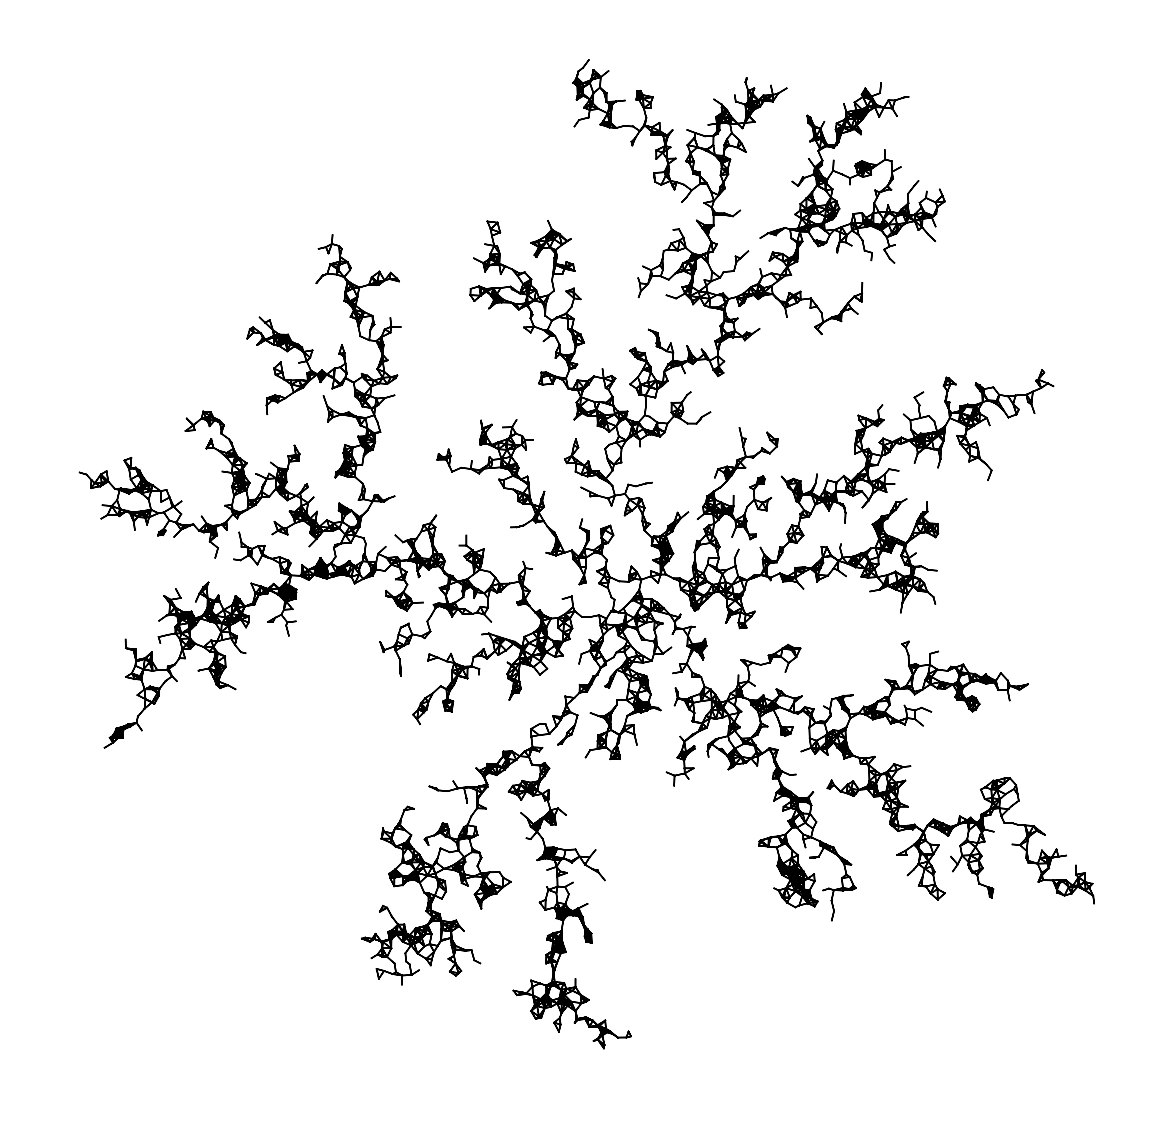

In [5]:
pop = sim.population.population

plt.figure(figsize=(20,20))
# plt.plot(pop[~pop.frozen].x, pop[~pop.frozen].y, ',', alpha=1, color='grey')
# plt.plot(pop[pop.frozen].x, pop[pop.frozen].y, 'k.', alpha=1)

frozen = pop[pop.frozen].loc[:, ['x', 'y']]
tree = sklearn.neighbors.KDTree(frozen.values, leaf_size=2)

nearest = tree.query_radius(frozen.values, r=0.1, count_only=False)
xx, yy = [], []
for i, N_i in enumerate(nearest):
    for j in N_i:
        xx += [frozen.iloc[i, 0], frozen.iloc[j, 0], np.nan]
        yy += [frozen.iloc[i, 1], frozen.iloc[j, 1], np.nan]
plt.plot(xx, yy, 'k-', alpha=1)

plt.axis('off');